In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imgrvt as rvt
import pims
import trackpy as tp
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel
from matplotlib.patches import Circle
%config InlineBackend.figure_format='retina'
from scipy.signal import find_peaks
from scipy.signal import peak_widths
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rc('xtick', labelsize=8)      # fontsize of the tick labels
plt.rc('ytick', labelsize=8)      # fontsize of the tick labels 
from sympy import *
cmap = matplotlib.colormaps['viridis']
cmap
from colormath.color_objects import XYZColor, sRGBColor
from colormath.color_conversions import convert_color
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
from sklearn.gaussian_process.kernels import RBF
from scipy.interpolate import CubicSpline
tab10 = plt.get_cmap("tab10")
viridis = plt.get_cmap("viridis")
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import LSQUnivariateSpline
import seaborn as sns

In [2]:
df_drops = pd.read_csv('23.11.21 drop_radius_knots v7 for 24.07.08 final droplets time_label (24.07.08 f01 0 to 2080).csv')

In [3]:
df_drops

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label
0,0,0,20,1377.000000,203.038610,0.335449,0.887494,0.210784,0.071234,0.338846,NaN,0,4,8.454164,1.667334,yes,0.0
1,1,1,19,1340.956954,429.927152,0.391141,0.866981,0.299559,0.097138,0.393561,NaN,0,5,4.601347,0.243574,no,0.0
2,2,2,18,1321.006250,1419.018750,0.207227,0.887412,0.238095,0.044036,0.210970,NaN,0,6,3.948327,0.074942,no,0.0
3,3,3,16,1171.967033,730.032967,0.353581,0.877058,0.300000,0.081596,0.356973,NaN,0,7,4.536045,0.150993,no,0.0
4,4,4,15,1135.923438,310.007812,0.828908,0.875000,0.289796,0.194275,0.832808,NaN,0,8,5.297901,1.536900,yes,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,1182,1182,1561,633.008065,1723.991935,0.128393,0.884454,0.278351,0.027956,0.129280,NaN,72,14,15.158502,3.106009,yes,72.0
1183,1183,1183,1562,1306.005155,1431.974227,0.100436,0.885158,0.276316,0.021744,0.101107,NaN,72,6,5.472040,0.310001,no,72.0
1184,1184,1184,1564,632.017544,1727.019737,0.106168,0.879842,0.294618,0.023981,0.106827,NaN,73,14,15.332640,3.105819,yes,73.0
1185,1185,1185,1563,383.950673,1445.026906,0.103840,0.857570,0.359756,0.027473,0.104330,NaN,73,18,9.128951,0.479715,no,73.0


In [4]:
# Identify columns that start with 'Unnamed:'
unwanted_columns = df_drops.filter(regex='^Unnamed:').columns

# Drop the unwanted columns
df_drops = df_drops.drop(columns=unwanted_columns)

In [5]:
df_drops

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label
0,1377.000000,203.038610,0.335449,0.887494,0.210784,0.071234,0.338846,NaN,0,4,8.454164,1.667334,yes,0.0
1,1340.956954,429.927152,0.391141,0.866981,0.299559,0.097138,0.393561,NaN,0,5,4.601347,0.243574,no,0.0
2,1321.006250,1419.018750,0.207227,0.887412,0.238095,0.044036,0.210970,NaN,0,6,3.948327,0.074942,no,0.0
3,1171.967033,730.032967,0.353581,0.877058,0.300000,0.081596,0.356973,NaN,0,7,4.536045,0.150993,no,0.0
4,1135.923438,310.007812,0.828908,0.875000,0.289796,0.194275,0.832808,NaN,0,8,5.297901,1.536900,yes,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,633.008065,1723.991935,0.128393,0.884454,0.278351,0.027956,0.129280,NaN,72,14,15.158502,3.106009,yes,72.0
1183,1306.005155,1431.974227,0.100436,0.885158,0.276316,0.021744,0.101107,NaN,72,6,5.472040,0.310001,no,72.0
1184,632.017544,1727.019737,0.106168,0.879842,0.294618,0.023981,0.106827,NaN,73,14,15.332640,3.105819,yes,73.0
1185,383.950673,1445.026906,0.103840,0.857570,0.359756,0.027473,0.104330,NaN,73,18,9.128951,0.479715,no,73.0


In [6]:
df_ph = pd.read_csv('chamber1_analysis_v3 (nm 24.09.23) pH calibration v3 24.07.08 capillary experiments.csv')


In [7]:
# Identify columns that start with 'Unnamed:'
unwanted_columns = df_ph.filter(regex='^Unnamed:').columns

# Drop the unwanted columns
df_ph = df_ph.drop(columns=unwanted_columns)

In [8]:
df_ph

,time,loc,x,r,g,b,unknown,X,Y,Z,x_color,y_color,delta,pH,epsilon,pHlow,pHhigh
0,0,0,0,73.837629,82.380155,116.613402,NaN,0.087804,0.086941,0.135385,0.283119,0.280337,0.876718,9.791961,0.020597,9.714537,9.881440
1,0,0,1,73.837629,82.871134,116.613402,NaN,0.088206,0.087690,0.135487,0.283272,0.281615,0.867622,9.756515,0.020367,9.684048,9.839147
2,0,0,2,73.169459,82.239691,116.188789,NaN,0.086953,0.086369,0.134357,0.282609,0.280711,0.876380,9.790606,0.020570,9.713443,9.879724
3,0,0,3,73.920747,82.713918,116.317655,NaN,0.088007,0.087426,0.134772,0.283707,0.281833,0.864372,9.744353,0.020299,9.673461,9.824844
4,0,0,4,73.235180,82.230670,115.947809,NaN,0.086887,0.086335,0.133802,0.282997,0.281200,0.871507,9.771392,0.020457,9.696914,9.856782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348795,201,10,2075,74.869845,82.087629,114.842139,NaN,0.087596,0.086583,0.131286,0.286762,0.283448,0.841205,9.664064,0.019820,9.602629,9.732078
3348796,201,10,2076,74.281572,81.659149,114.661082,NaN,0.086683,0.085655,0.130771,0.285978,0.282588,0.849971,9.693229,0.020011,9.628505,9.765507
3348797,201,10,2077,74.934923,81.994845,114.806057,NaN,0.087557,0.086463,0.131186,0.286879,0.283294,0.841700,9.665677,0.019836,9.604050,9.733935
3348798,201,10,2078,74.903351,81.734536,115.118557,NaN,0.087463,0.086118,0.131844,0.286366,0.281961,0.852411,9.701594,0.020084,9.635828,9.775236


In [9]:

pH_mapping = df_ph.set_index(['loc','time', 'x'])['pH'].to_dict()

def calculate_pH(row, pH_mapping, df_ph):

    loc = 1
    time_label = row['time_label'] 
    x_center = round(row['x'])  

    pixel = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] == x_center)]
    
    if not pixel['pH'].empty:
        pH_drop = pixel['pH'].values[0]
        #print(pH_drop)
    else:
        pH_drop = np.nan 

    return pH_drop

df_drops['pH'] = df_drops.apply(lambda row: calculate_pH(row, pH_mapping, df_ph), axis=1)


In [10]:

pH_mapping = df_ph.set_index(['loc','time', 'x'])['pHlow'].to_dict()

def calculate_pHlow(row, pH_mapping, df_ph):
    loc = 1
    time_label = row['time_label'] 
    x_center = round(row['x']) 


    pixel = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] == x_center)]
    
    if not pixel['pHlow'].empty:
        pH_low = pixel['pHlow'].values[0]  # Access the first pH value
    else:
        pH_low = np.nan 

    return pH_low

# Apply the function to create a new "pH" column in final_droplets
df_drops['pHlow'] = df_drops.apply(lambda row: calculate_pHlow(row, pH_mapping, df_ph), axis=1)


In [11]:

pH_mapping = df_ph.set_index(['loc','time', 'x'])['pHhigh'].to_dict()

def calculate_pHhigh(row, pH_mapping, df_ph):
    loc = 1
    time_label = row['time_label'] 
    x_center = round(row['x']) 

    pixel = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] == x_center)]
    
    if not pixel['pHhigh'].empty:
        pH_high = pixel['pHhigh'].values[0]  # Access the first pH value
    else:
        pH_high = np.nan 

    return pH_high

# Apply the function to create a new "pH" column in final_droplets
df_drops['pHhigh'] = df_drops.apply(lambda row: calculate_pHhigh(row, pH_mapping, df_ph), axis=1)


In [12]:

delta_mapping = df_ph.set_index(['loc','time', 'x'])['delta'].to_dict()

def calculate_delta(row, delta_mapping, df_ph):
    loc = 1
    time_label = row['time_label'] 
    x_center = round(row['x'])  

    pixel = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] == x_center)]
    
    if not pixel['delta'].empty:
        delta = pixel['delta'].values[0]  # Access the first pH value
    else:
        delta = np.nan 

    return delta

# Apply the function to create a new "pH" column in final_droplets
df_drops['delta'] = df_drops.apply(lambda row: calculate_delta(row, delta_mapping, df_ph), axis=1)


In [13]:
epsilon_mapping = df_ph.set_index(['loc','time', 'x'])['epsilon'].to_dict()

def calculate_epsilon(row, epsilon_mapping, df_ph):
    loc = 1
    time_label = row['time_label'] 
    x_center = round(row['x'])  

    pixel = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] == x_center)]
    
    if not pixel['epsilon'].empty:
        epsilon = pixel['epsilon'].values[0]  # Access the first pH value
    else:
        epsilon = np.nan 

    return epsilon

# Apply the function to create a new "pH" column in final_droplets
df_drops['epsilon'] = df_drops.apply(lambda row: calculate_epsilon(row, epsilon_mapping, df_ph), axis=1)


In [14]:
# average pH over drop radius
pH_mapping = df_ph.set_index(['loc','time', 'x'])['pH'].to_dict()

def calculate_avg_pH(row, pH_mapping, df_ph):
    # variable names in the drop file
    loc = 1
    time_label = row['time_label'] 
    x_center = row['x']
    radius = row['radius']*6.76

    # Find pixels within the range of the particle center plus and minus the radius
    pixels_in_range = df_ph[(df_ph['loc'] == loc) & (df_ph['time'] == time_label) & (df_ph['x'] >= (x_center - radius)) & (df_ph['x'] <= (x_center + radius))]
    
    # Calculate the average pH within the range of pixels
    avg_pH = pixels_in_range['pH'].mean()


    return avg_pH

# Apply the function to create a new "pH" column in final_droplets
df_drops['avg pH'] = df_drops.apply(lambda row: calculate_avg_pH(row, pH_mapping, df_ph), axis=1)


In [15]:
df_drops.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label,pH,pHlow,pHhigh,delta,epsilon,avg pH
0,1377.000000,203.038610,0.335449,0.887494,0.210784,0.071234,0.338846,NaN,0,4,8.454164,1.667334,yes,0.0,9.247769,9.215592,9.280778,0.670106,0.016580,9.241773
1,1340.956954,429.927152,0.391141,0.866981,0.299559,0.097138,0.393561,NaN,0,5,4.601347,0.243574,no,0.0,9.288791,9.254918,9.323703,0.690642,0.016907,9.268759
2,1321.006250,1419.018750,0.207227,0.887412,0.238095,0.044036,0.210970,NaN,0,6,3.948327,0.074942,no,0.0,9.315070,9.279956,9.351379,0.703419,0.017140,9.316818
3,1171.967033,730.032967,0.353581,0.877058,0.300000,0.081596,0.356973,NaN,0,7,4.536045,0.150993,no,0.0,9.311135,9.276233,9.347207,0.701525,0.017096,9.277644
4,1135.923438,310.007812,0.828908,0.875000,0.289796,0.194275,0.832808,NaN,0,8,5.297901,1.536900,yes,0.0,9.276452,9.243091,9.310786,0.684539,0.016818,9.260339


## calculate dpH/dt

In [16]:
scan_rate = 0.167 # min/frame

In [17]:
df_drops = df_drops.sort_values(by=['time_label', 'particle'])

In [18]:
def calculate_dt(group):
    group['dt'] = ((group['time_label'].diff())*scan_rate).fillna(0)
    group.loc[group['time_label'] == 0, 'dt'] = scan_rate
    return group

# Apply the function to calculate time intervals within each particle group
df_drops = df_drops.groupby('particle').apply(calculate_dt)

In [19]:
# Function to calculate central difference with variable time intervals
def central_difference(ph_values, dt):
    diff_values = (ph_values.shift(-1) - ph_values.shift(1)) / (dt.shift(-1) + dt.shift(0))
    
    # Forward differencing for the first frame
    diff_values.iloc[0] = (ph_values.iloc[1] - ph_values.iloc[0]) / scan_rate if len(ph_values) > 1 else np.nan
    
    # Backward differencing for the last frame
    diff_values.iloc[-1] = (ph_values.iloc[-1] - ph_values.iloc[-2]) / dt.iloc[-1] if len(ph_values) > 1 else np.nan
    return diff_values

# Apply central difference calculation to 'pH' grouped by 'particle' with variable time intervals
df_drops['dpH/dt'] = df_drops.groupby('particle').apply(lambda x: central_difference(x['pH'], x['dt'])).reset_index(level=0, drop=True)
#print(index)

In [20]:
df_drops

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,...,vacuole,time_label,pH,pHlow,pHhigh,delta,epsilon,avg pH,dt,dpH/dt
0,1377.000000,203.038610,0.335449,0.887494,0.210784,0.071234,0.338846,NaN,0,4,...,yes,0.0,9.247769,9.215592,9.280778,0.670106,0.016580,9.241773,0.167,-0.019370
1,1340.956954,429.927152,0.391141,0.866981,0.299559,0.097138,0.393561,NaN,0,5,...,no,0.0,9.288791,9.254918,9.323703,0.690642,0.016907,9.268759,0.167,-0.094009
2,1321.006250,1419.018750,0.207227,0.887412,0.238095,0.044036,0.210970,NaN,0,6,...,no,0.0,9.315070,9.279956,9.351379,0.703419,0.017140,9.316818,0.167,-0.027408
3,1171.967033,730.032967,0.353581,0.877058,0.300000,0.081596,0.356973,NaN,0,7,...,no,0.0,9.311135,9.276233,9.347207,0.701525,0.017096,9.277644,0.167,-0.116987
4,1135.923438,310.007812,0.828908,0.875000,0.289796,0.194275,0.832808,NaN,0,8,...,yes,0.0,9.276452,9.243091,9.310786,0.684539,0.016818,9.260339,0.167,-0.120422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,633.008065,1723.991935,0.128393,0.884454,0.278351,0.027956,0.129280,NaN,72,14,...,yes,72.0,7.319837,7.065475,7.482006,0.023418,0.010244,7.316648,0.167,-0.623337
1180,382.991770,1444.004115,0.125804,0.863050,0.337017,0.032098,0.126341,NaN,72,18,...,no,72.0,7.134438,6.659166,7.359531,0.015406,0.010195,7.096856,0.167,-0.653009
1186,632.013304,1849.037694,0.105004,0.874624,0.321739,0.024679,0.105636,NaN,73,13,...,yes,73.0,7.409279,7.211529,7.547136,0.028620,0.010276,7.405598,0.167,-0.346228
1184,632.017544,1727.019737,0.106168,0.879842,0.294618,0.023981,0.106827,NaN,73,14,...,yes,73.0,7.179018,6.777884,7.387347,0.017043,0.010206,7.240687,0.167,-0.843229


In [26]:
df_drops.to_csv('24.09.23 updating pH calibration v3 for drops dphdt (24.07.08 f01 0-2080) nm.csv')

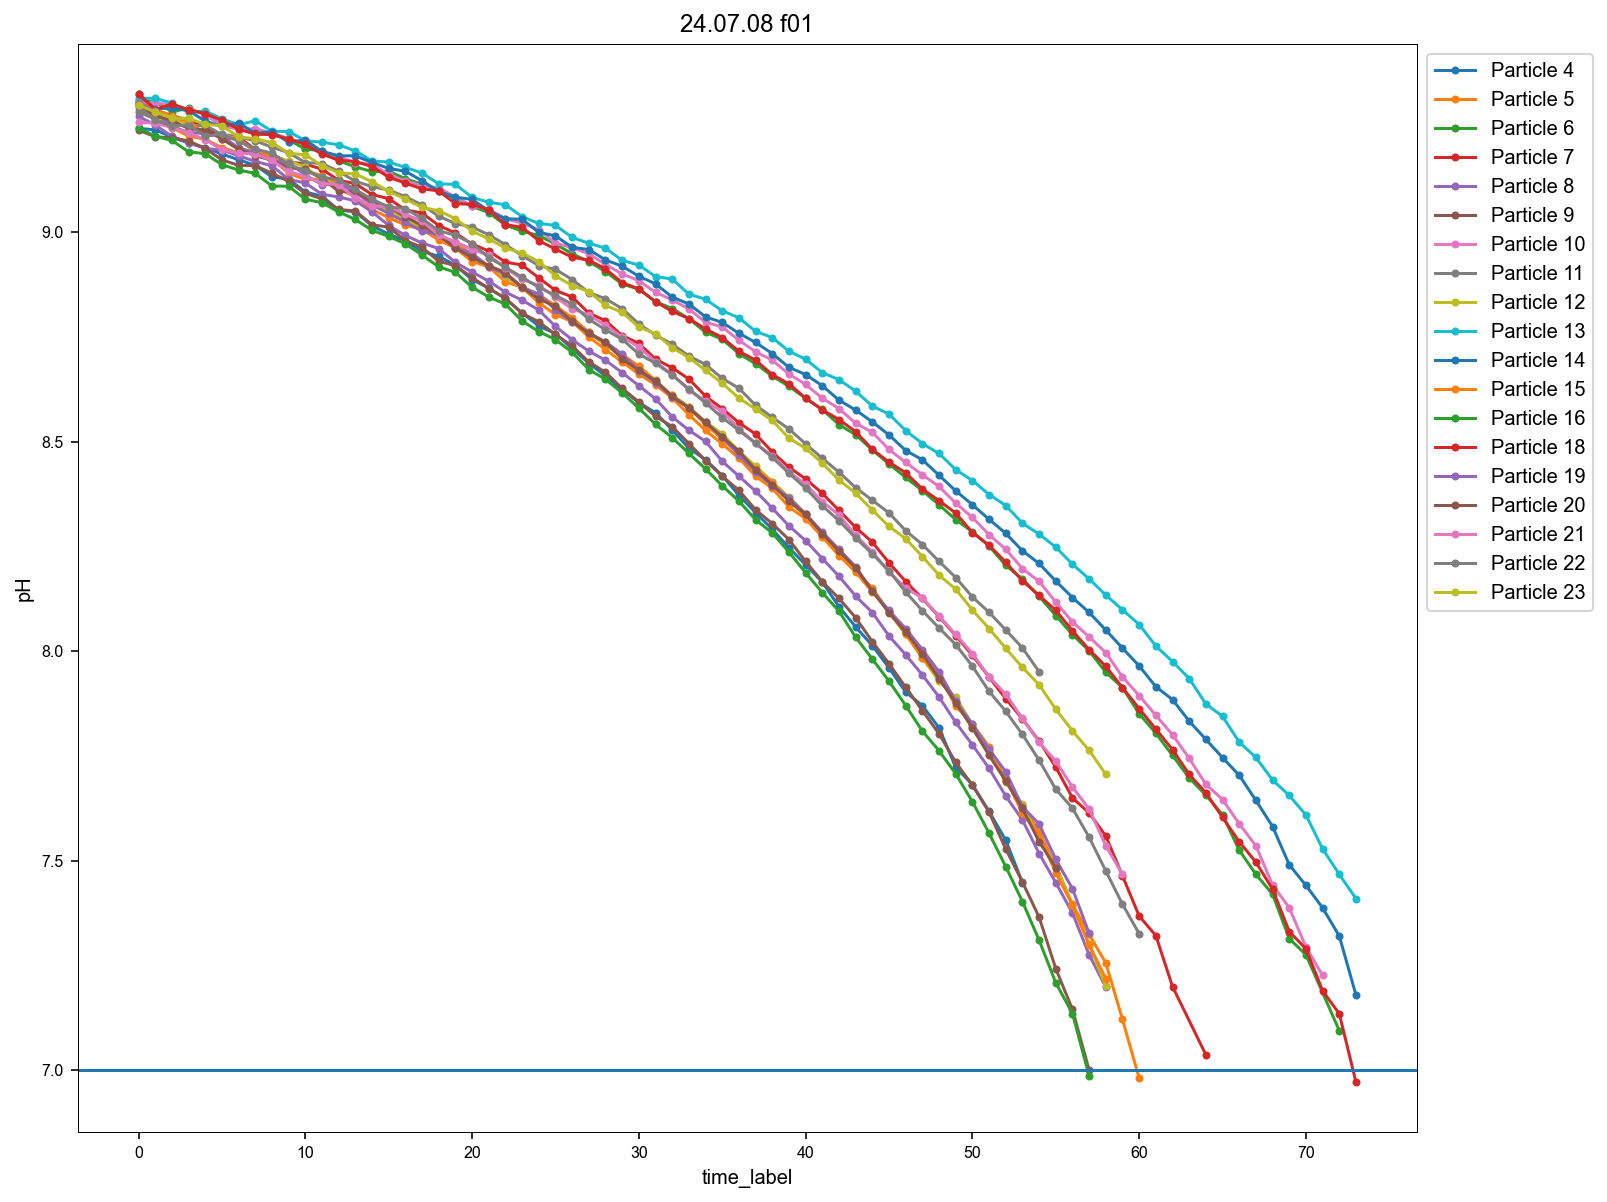

In [22]:

plt.figure(figsize=(12, 10))

# Iterate through each unique particle
for particle in df_drops['particle'].unique():
    mask = df_drops['particle'] == particle
    data = df_drops[mask]
    plt.plot(data['time_label'], data['pH'], '.-', label=f'Particle {particle}')

plt.title('24.07.08 f01')
plt.xlabel('time_label')
plt.ylabel('pH')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axhline(y=7)

plt.show()

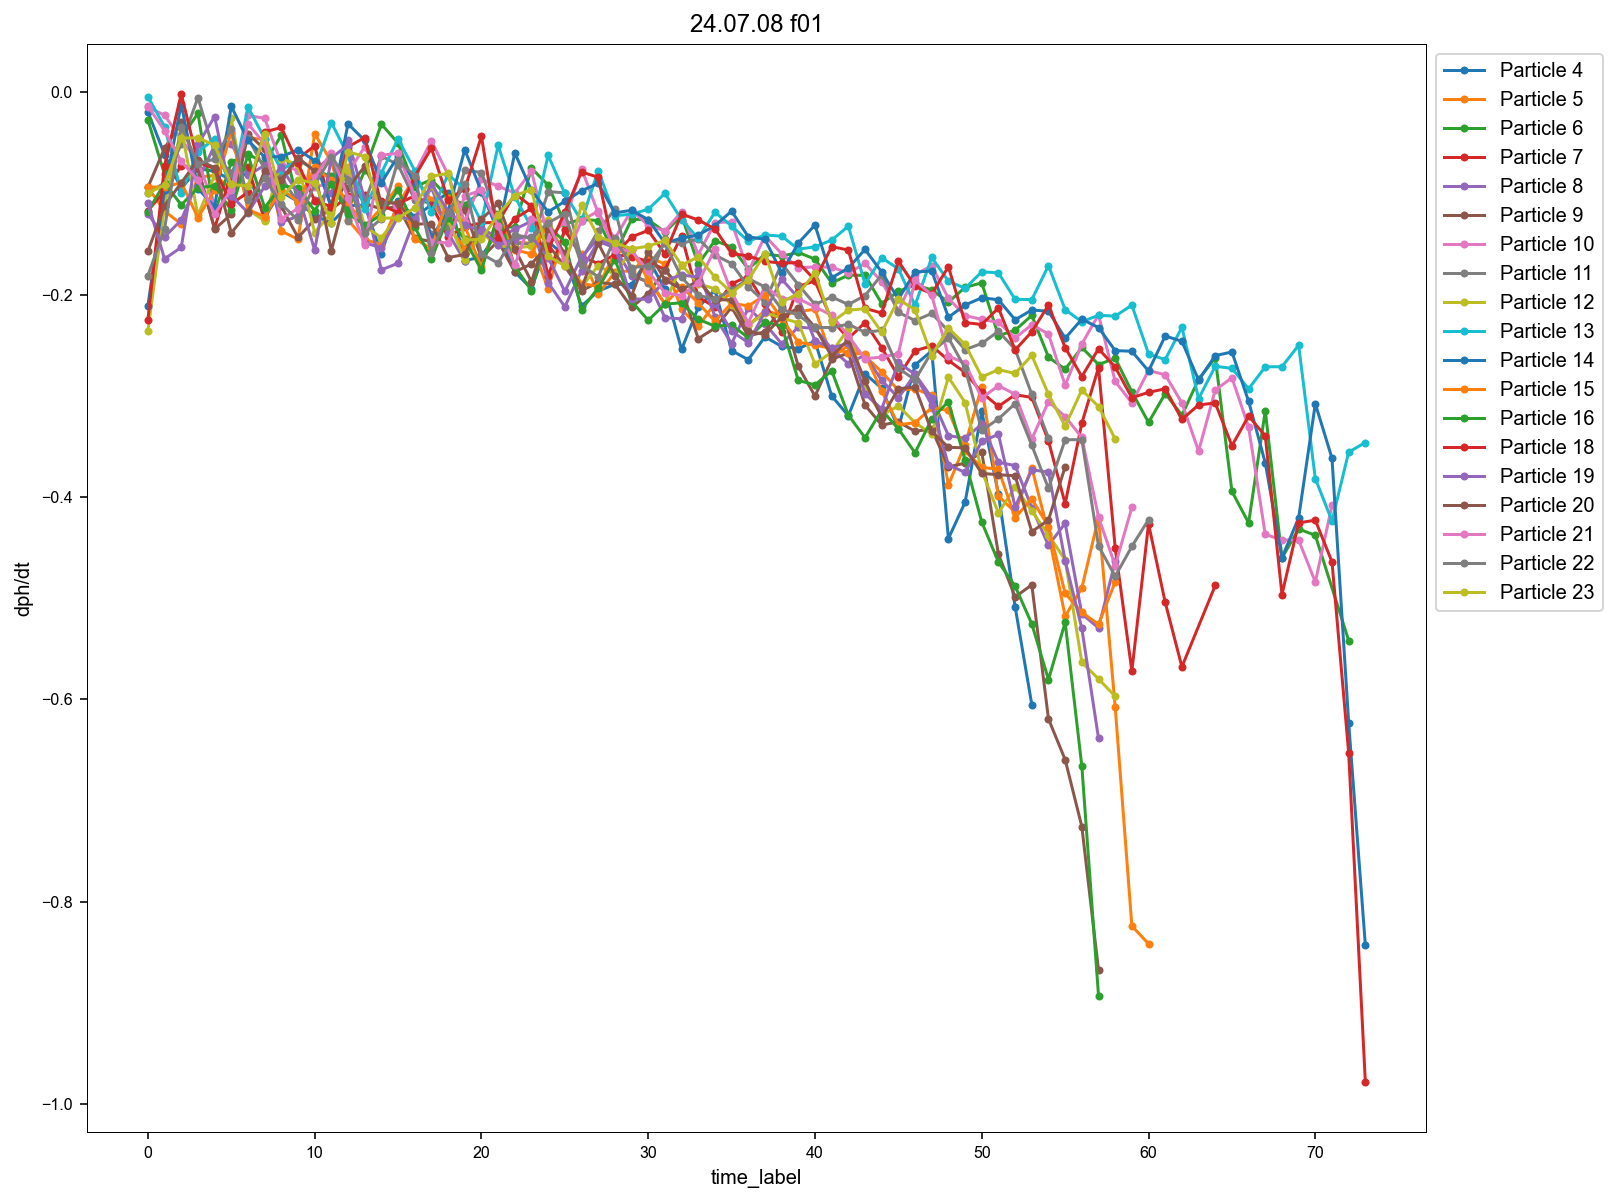

In [23]:

plt.figure(figsize=(12, 10))

# Iterate through each unique particle
for particle in df_drops['particle'].unique():
    mask = df_drops['particle'] == particle
    data = df_drops[mask]
    plt.plot(data['time_label'], data['dpH/dt'], '.-', label=f'Particle {particle}')
        
plt.title('24.07.08 f01')
plt.xlabel('time_label')
plt.ylabel('dph/dt')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

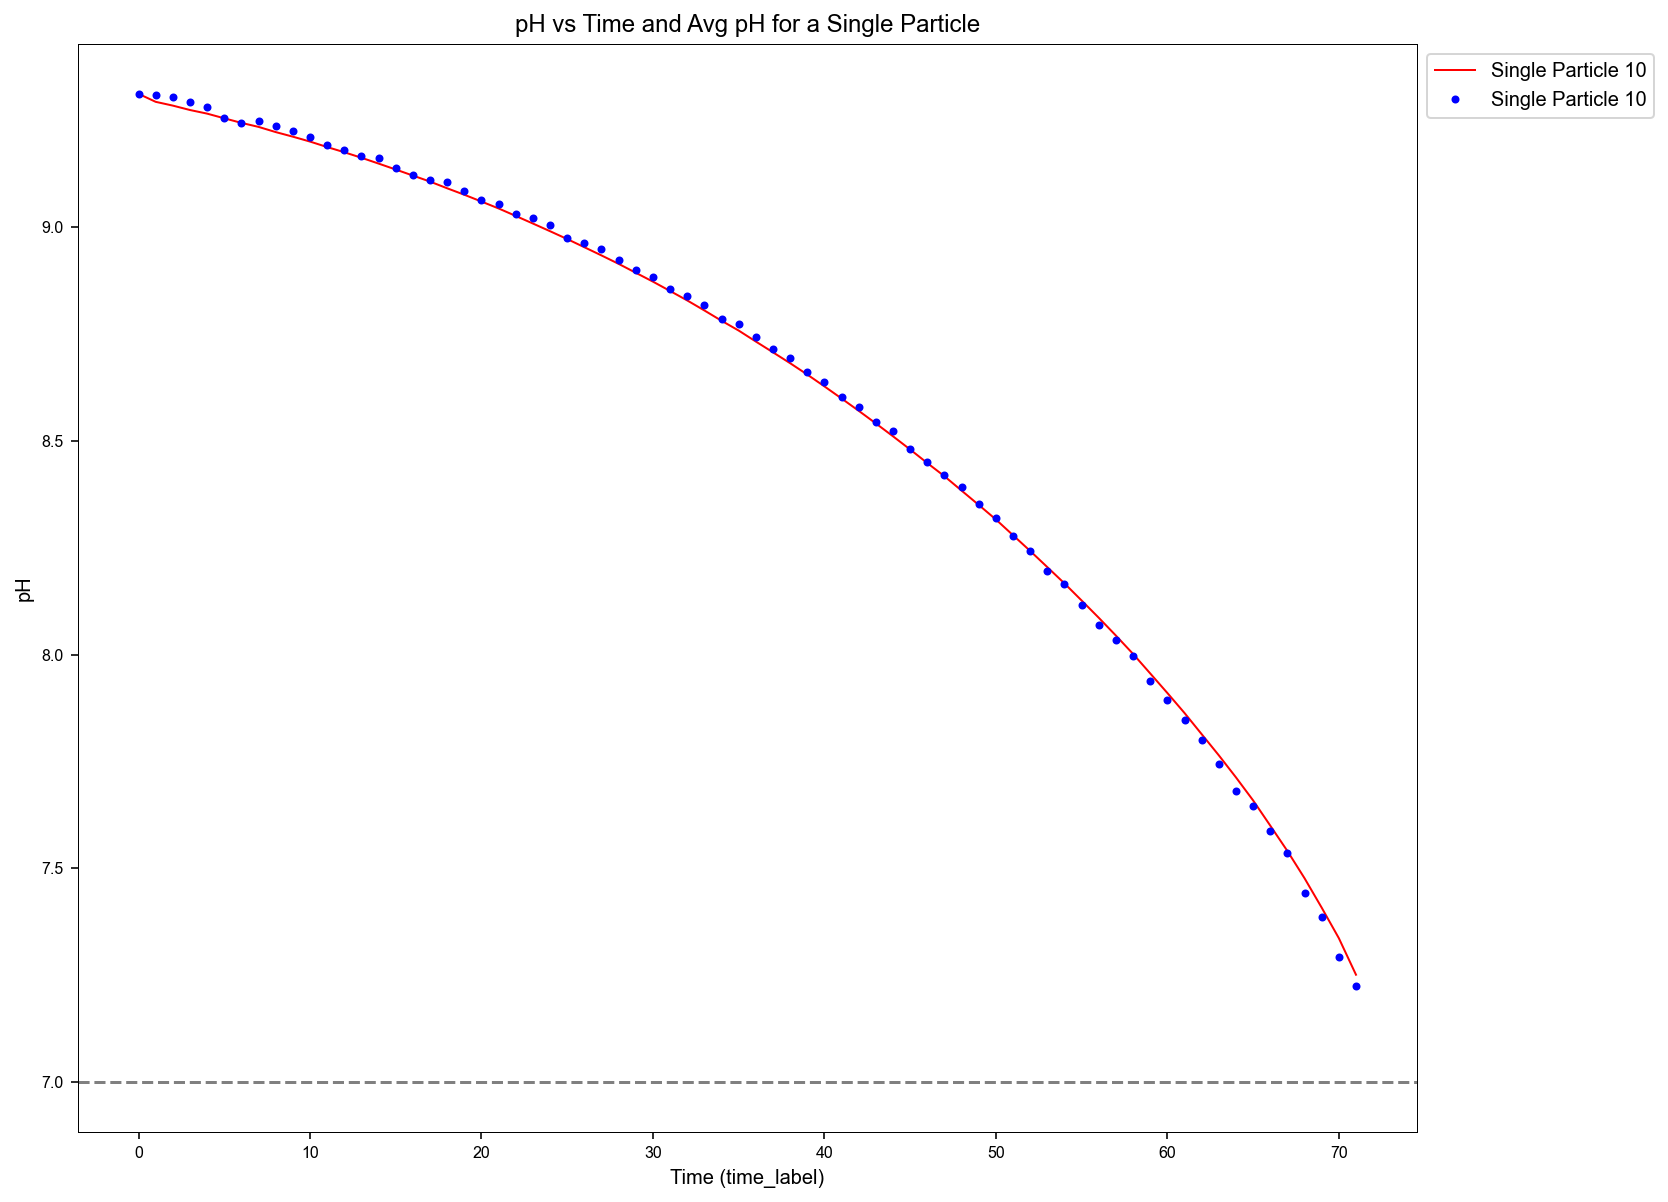

In [24]:

plt.figure(figsize=(12, 10))


particle_id = 10

# Plot avg pH for the selected particle
mask = df_drops['particle'] == particle_id
data = df_drops[mask]


plt.plot(data['time_label'], data['avg pH'], '-', color='red', label=f'Single Particle {particle_id}', linewidth=1)
plt.plot(data['time_label'], data['pH'], '.', color='blue', label=f'Single Particle {particle_id}', linewidth=1)

plt.title('pH vs Time and Avg pH for a Single Particle')
plt.xlabel('Time (time_label)')
plt.ylabel('pH')
plt.axhline(y=7, color='gray', linestyle='--')  # Horizontal line at pH 7
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()
